In [1]:
import rmtchem 
import timeit
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.integrate import solve_bvp
from scipy.signal import argrelmax,find_peaks
import imp
import cantera as ct
imp.reload(rmtchem)
from scipy.sparse import csr_matrix
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
import warnings
warnings.filterwarnings("ignore")

/var/folders/37/5qnc4jls0l90nkqjm2xxg1bm0000gp/T/ipykernel_71361/3050298409.py:8: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


### Saddle-node bifurcations

In [73]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.0*nr)
# na=int(0.25*nr)
seed=997 #SN
seed=570
natoms=3
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,natoms,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
m=(eta[::2]-nu[::2]).T.dot(nu[::2]-eta[::2])
print(len(lcc),np.linalg.matrix_rank(m))

64 133 6 0 570
1	3	
1	3	1	3	
277	132	
64 61


Pseudoarclength continuation

since the drive is the only source of atoms, conserved quantities remain if atoms[drive] is has a null space. We need more driving species than conserved quantities...or we can treat a randomly selected subset as fixed by the remaining atomic constraints.


9.23854e+00	9.85261e-02	-1.64491e-02	2.23963e-03	408	1	3.07672e-08	
Saddle-node bifurcation!	9.239560
3.90867e+00	9.85261e-02	9.27625e-03	-1.43595e-04	600	1	2.23574e-13		
Saddle-node bifurcation!	3.922695
6.66680e+00	1.13906e-03	3.51112e-01	4.30109e-04	762	11	1.00006e-17	
Bad pseudoarclength conditioning!	6.666796

Bad pseudoarclength conditioning!	6.666796

Bad pseudoarclength conditioning!	6.666796

Bad pseudoarclength conditioning!	6.666796

Bad pseudoarclength conditioning!	6.666796
6.66660e+00	2.25000e-04	3.51170e-01	5.28501e-04	767	11	9.99173e-18	
Failed to converge at SN!

 11.413956546923146


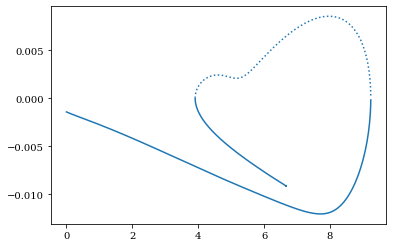

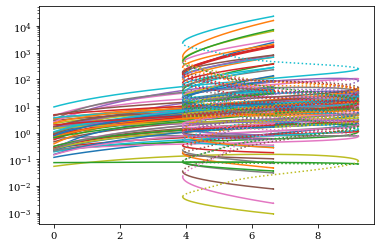

In [74]:
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.pseudoarclength_log(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-4, dsmax=1e-1,output=2,stop=False)

stop=timeit.default_timer()
print('\n',stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

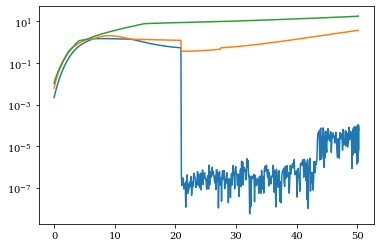

In [62]:
from scipy.linalg import null_space
from scipy.linalg import eig

X=Xs[10]
ep=epsilons[10]
t=0
evs=[]
evecs=[]

for i in range(len(Xs)):
    X=Xs[i]
    ep=epsilons[i]

    a=rmtchem.jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)*X[np.newaxis,:]
    b=XD1[:,np.newaxis]
    A=np.hstack([a,b])

    dx=null_space(A)[:,0]
    if dx[-1]<0:
        dx=-dx
        
    c=dx[:-1]
    d=np.array([dx[-1]])
    B=np.hstack([c,d])

    ev,evec=eig(np.vstack([A,B]))
    evs=evs+[ev]
    evecs=evecs+[evec]
    
for i in range(3):
    plt.plot(epsilons,np.abs(np.real(np.array(evs)[np.arange(len(evs)),np.argsort(np.abs(evs),axis=1)[:,i]])))
plt.yscale('log')

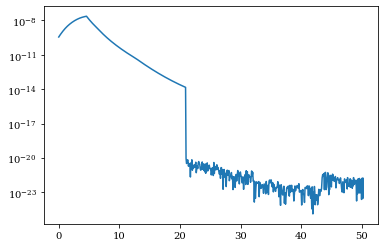

In [72]:
test1=np.abs(np.real(np.array(evs)[np.arange(len(evs)),np.argsort(np.abs(evs),axis=1)[:,0]]))
test2=np.abs(np.real(np.array(evs)[np.arange(len(evs)),np.argsort(np.abs(evs),axis=1)[:,-1]]))
plt.plot(epsilons,test1/test2)
plt.yscale('log')

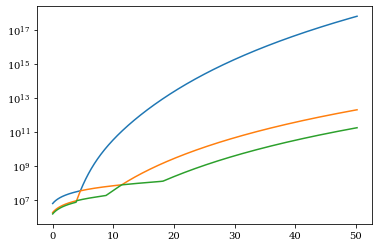

In [63]:
for i in range(1,4):
    plt.plot(epsilons,np.abs(np.real(np.array(evs)[np.arange(len(evs)),np.argsort(np.abs(evs),axis=1)[:,-i]])))
plt.yscale('log')

1.00475e+02	7.59375e-04	4.69955e-04	6.86482e-01	2447	1	6.14492e-11	
 38.34099822607823


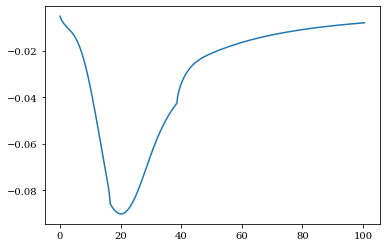

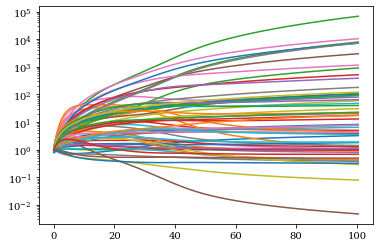

In [4]:
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.pseudoarclength(X0, eta, nu, k, XD1, XD2, 0, 100, ds=1e-4, dsmax=1e-3,output=2,stop=False)

stop=timeit.default_timer()
print('\n',stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

Natural parameter continuation

In [77]:
imp.reload(rmtchem)

<module 'rmtchem' from '/Users/zack/Documents/rmtchem/rmtchem.py'>

0.999900	1.000000e-02	10000	
 55.068989463034086


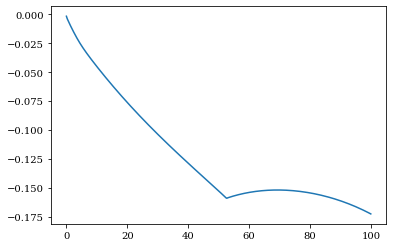

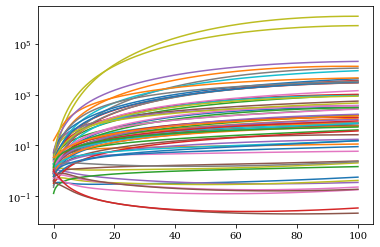

In [10]:
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-2,output=2,depmin=1e-14,stop=False)
stop=timeit.default_timer()
print('\n',stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

64 133 6 66 2
1	3	
1	3	1	3	
21750	132	
60.784591759998875-02	10000	


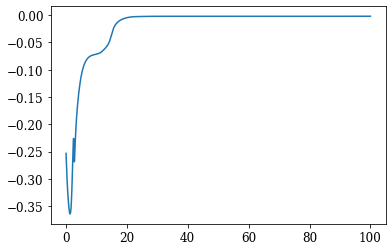

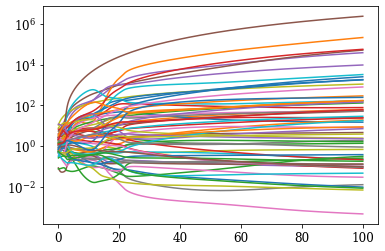

In [241]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
seed=2
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G,atoms=rmtchem.get_network(n,nr,na,5,True) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]

d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()
Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-2,output=2,depmin=1e-14,stop=False)
stop=timeit.default_timer()
print(stop-start)
plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]

for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls='-',color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    plt.plot(epsilons[inds],np.max(np.real(evals),axis=1)[inds],ls=':',color=colors[0])
plt.show()

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

83.5053515625057 1138.9370953548344 0.0843909454594686
0.000002	0.000000	1012	0	lsoda	
Found steady state!
True 0.67491242899996


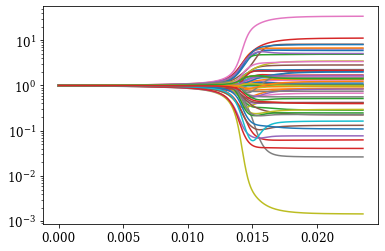

1058 1059


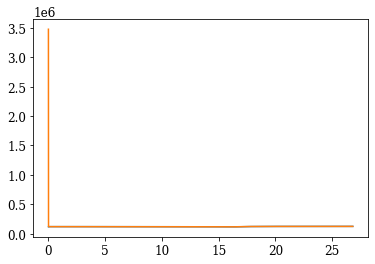

119835.24119939987 124258.77048932937 119835.2411993481 124258.77048927963 38.061629854915964 535.8884000137132


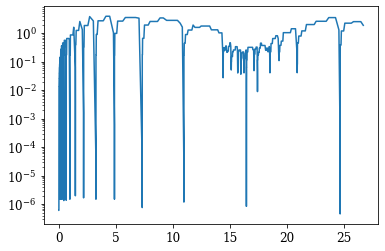

0


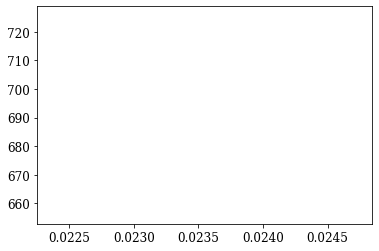

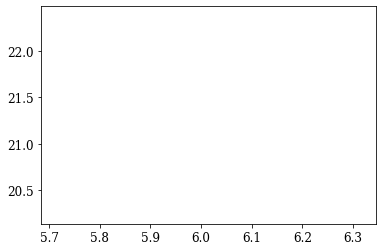

In [12]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)

epsilon=epsilons[m0]+1e-1
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
print(m0,len(ts))
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
dn1=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm((Xts[:,i]-X0)/X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
dn2=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm(Xts[:,i]-X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2, dn1,dn2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


In [13]:
np.save('data/sn/Xs.npy',Xs)
np.save('data/sn/epsilons.npy',epsilons)
np.save('data/sn/evals.npy',evals)
np.save('data/sn/ts.npy',ts)
np.save('data/sn/Xts.npy',Xts)

### Hopf bifurcations

64 133 6 0 21
0.426500	1.000000e-02	4266	
Subcritical Hopf bifurcation!		42.650000


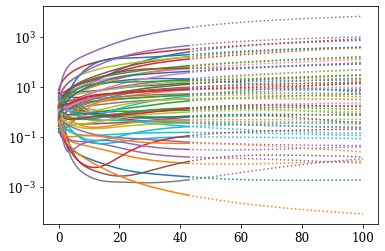

In [15]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=0
seed=21
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-2,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

42.66000000000008 153326.93695027573 0.4355232055954667
0.000001	0.000000	51877	1092	lsoda	
Found oscillating state!
True 23.32943986800001


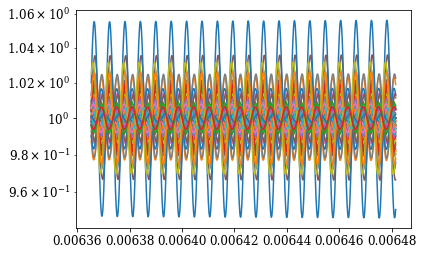

51338 52530


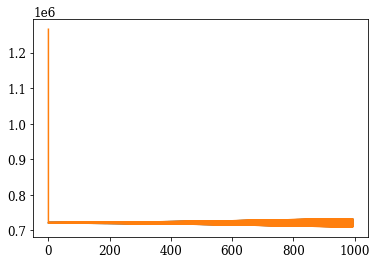

720951.6328205217 721409.9071922813 720951.6328205673 721407.7025407527 0.07377690944255158 8.201820656554366


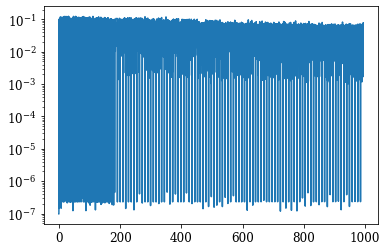

1


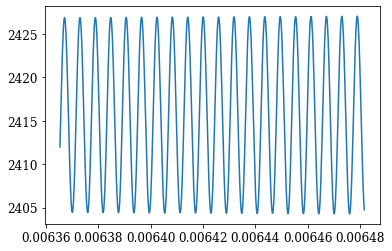

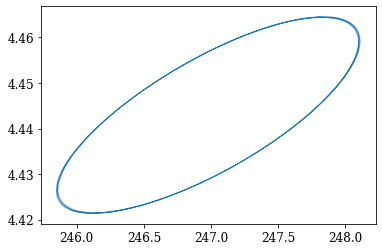

In [38]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilons[m0])*XD1, XD2)
epsilon=epsilons[m0]+1e-2
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True,maxcycles=200)
m0=int(m0+9*(len(ts)-m0)/10)

stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts[m0:]/tscale,np.transpose(Xts)[m0:]/X0)
plt.show()

sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
print(m0,len(ts))
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
dn1=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm((Xts[:,i]-X0)/X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
dn2=np.sum(np.diff(ts)[m0-1:]*[np.linalg.norm(Xts[:,i]-X0) for i in range(m0,len(ts))])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2, dn1,dn2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


In [39]:
np.save('data/hopf/Xs.npy',Xs)
np.save('data/hopf/epsilons.npy',epsilons)
np.save('data/hopf/evals.npy',evals)
np.save('data/hopf/ts.npy',ts)
np.save('data/hopf/Xts.npy',Xts)

### Chemical chaos 

64 133 6 66 1010
0.106300	1.000000e-02	1064	
Supercritical Hopf bifurcation!		10.630000
0.144137	1.000000e-02	1472	
Subcritical Hopf bifurcation!		14.413750
0.182138	1.000000e-02	1852	
Subcritical Hopf bifurcation!		18.213750
0.262625	4.882813e-06	2761	
Saddle-node bifurcation!	26.262510	4.882813e-06	1	1	4.057656	0.000000	4	3	4	
0.140435	-4.882813e-06	4248	
Saddle-node bifurcation!	14.043467	-4.882813e-06	1	1	0.000000	3.827767	1	1	0	
0.150171	1.250000e-03	5093	
Subcritical Hopf bifurcation!		15.017148
0.659769	9.765625e-06	11777	
Saddle-node bifurcation!	65.976943	9.765625e-06	1	1	3.921439	0.000000	2	3	2	
0.203754	-4.882813e-06	16675	
Saddle-node bifurcation!	20.375366	-4.882813e-06	1	1	4.038006	0.000000	3	2	3	
0.213053	1.000000e-02	16864	
Subcritical Hopf bifurcation!		21.305298
0.557077	4.882813e-06	20383	
Saddle-node bifurcation!	55.707744	4.882813e-06	1	1	0.000000	4.008828	0	0	1	
0.256065	-4.882813e-06	23600	
Saddle-node bifurcation!	25.606470	-4.882813e-06	1	1	0.000000	4.383892	7	

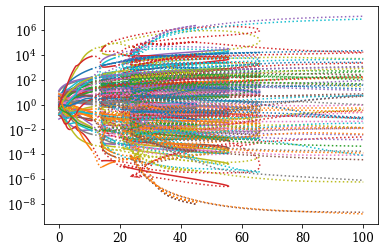

In [41]:
imp.reload(rmtchem)
n=64
nr=int(0.5*n*np.log(n))
nd=int(0.1*n)
na=int(0.5*nr)
seed=1010
print(n,nr,nd,na,seed)

np.random.seed(seed)
eta,nu,k,G=rmtchem.get_network(n,nr,na) 
row,col=np.where(eta[::2]-nu[::2]!=0)
data=(eta[::2]-nu[::2])[row,col]
A=csr_matrix((data,(row,col)),shape=(2*nr,n),dtype=int)
adj=A.T.dot(A)
g=nx.convert_matrix.from_scipy_sparse_matrix(adj)
lcc=np.array(list(max(nx.connected_components(g), key=len)))
n=len(lcc)
eta=eta[:,lcc]
nu=nu[:,lcc]
G=G[lcc]
d0=1e6
d1min=0
d1max=100
XD1,XD2,inds=rmtchem.get_drive(eta,nu,k,G,d0,nd)
X0=np.exp(-G)
start=timeit.default_timer()

Xs,epsilons,evals,bif=rmtchem.quasistatic(X0, eta, nu, k, XD1, XD2, d1min,d1max,d1min,1e-2,output=2,stop=False)

plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(n):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

20 57.85404924427026 0.00012097183746864293


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


/Users/zack/Documents/rmtchem/rmtchem.py:131: RuntimeWarning: divide by zero encountered in true_divide
  dt=np.min([np.mean(10/tscales[tinds[:-1]]),100*dt0,ts[-1]/2,dtmax])


0.014190	0.000209	5850	99	irk  	Unexpected istate in LSODA.
Found oscillating state!
True 7.0127434910000375


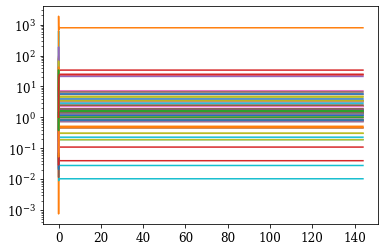

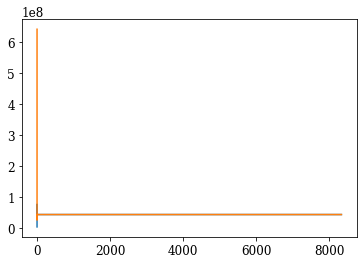

2678823.1087422688 42635553.72898769 634193247.0682617 42635553.72896941


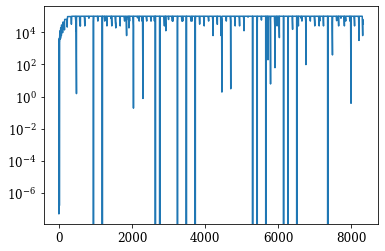

1


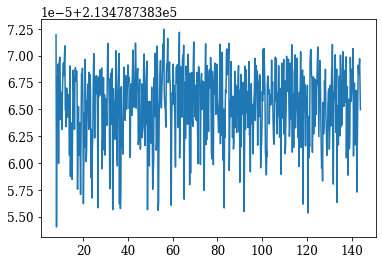

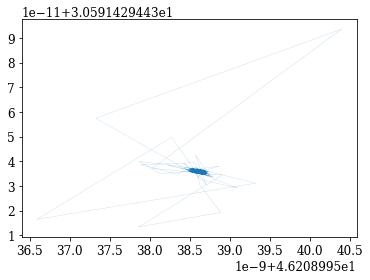

In [42]:
imp.reload(rmtchem)
m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=20
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))
tscale=2*np.pi/np.abs(np.real(ev[np.argmin(np.abs(np.real(ev)))]))
dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e4*tscale,dt,output=True)

stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()
sd=[rmtchem.Sdot(rmtchem.rates(Xts[:,i],eta,nu,k)) for i in range(len(ts))]
wd=[rmtchem.Wdot(Xts[:,i],G,(1+epsilon)*XD1,XD2) for i in range(len(ts))]
sd1=rmtchem.Sdot(rmtchem.rates(X0,eta,nu,k))
wd1=rmtchem.Wdot(X0, G, (1+epsilon-1e-1)*XD1, XD2)
sd2=np.sum(np.diff(ts)[m0-1:]*sd[m0:])/np.sum(np.diff(ts)[m0-1:])
wd2=np.sum(np.diff(ts)[m0-1:]*wd[m0:])/ np.sum(np.diff(ts)[m0-1:])
plt.plot(ts,sd)
plt.plot(ts,wd)
plt.show()
print(sd1, sd2, wd1, wd2)

plt.yscale('log')
plt.plot(ts[:-1],np.diff(ts)/dt)
plt.show()
print(state)
plt.plot(ts[m0:]/tscale,np.linalg.norm(Xts,axis=0)[m0:])
plt.show()
plt.plot(Xts[0,m0:],Xts[1,m0:],linewidth=0.1)
plt.show()


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


0.713588	0.286412	4941	11	irk  	Unexpected istate in LSODA.
Failed to find state before maxtime 578.5404924427025


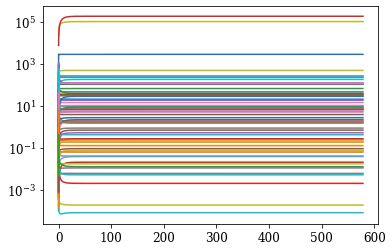

/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


0.350831	0.175415	471876	0	irk  	Unexpected istate in LSODA.
Found steady state!
5.262462870665838 True


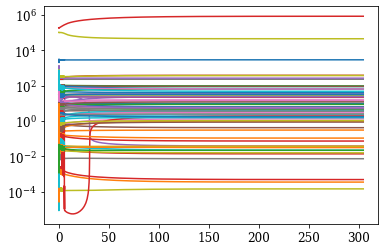

In [43]:
imp.reload(rmtchem)
np.random.seed(1)
ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,10*dt,output=True,cont=True)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()
ts,Xts,success,m0,state=rmtchem.integrate(Xts[:,-1]*(1+1e-2*(0.5-np.random.random(size=len(X0)))),eta,nu,k,(1+epsilon)*XD1,XD2,1e1*tscale,dt,output=True,cont=False,maxsteps=1e7)
print(ts[-1]/tscale,success)
plt.yscale('log')
plt.plot(ts,np.transpose(Xts))
plt.show()

In [44]:
success,solx=rmtchem.steady(Xts[:,-1],eta,nu,k,(1+epsilon)*XD1,XD2)
print(success,np.linalg.norm((solx-Xts[:,-1])/solx))
ev,evecs=np.linalg.eig(rmtchem.jac(0,solx,eta,nu,k,(1+epsilon)*XD1,XD2))
print(ev[np.argmax(np.real(ev))])

True 0.0
(-0.022855819914751975+0j)


0.365176	1.000000e-02	1808	
Subcritical Hopf bifurcation!		36.517578
0.366579	4.882813e-06	1951	
Saddle-node bifurcation!	36.657866	4.882813e-06	1	1	0.000657	4.306462	4	4	3	
0.061400	-1.000000e-02	1387	
Subcritical Hopf bifurcation!		6.140000
0.061388	-6.103516e-07	1406	
Saddle-node bifurcation!	6.138784	-6.103516e-07	1	1	0.000000	45.493017	2	2	1	
0.366579	4.882813e-06	4866	
Saddle-node bifurcation!	36.657883	4.882813e-06	1	1	0.000554	3.864281	3	3	4	
0.365130	-2.500000e-03	4997	
Subcritical Hopf bifurcation!		36.512966


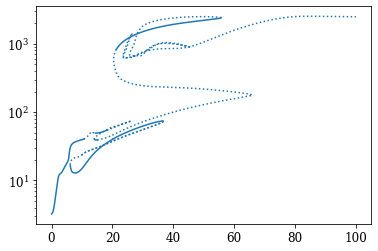

In [45]:
imp.reload(rmtchem)
X2s,epsilon2s,eval2s,bif2=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,1e-2,output=2,stepsmax=5000,stop=False)
X3s,epsilon3s,eval3s,bif3=rmtchem.quasistatic(solx, eta, nu, k, XD1, XD2, d1min,d1max,epsilon,-1e-2,output=2,stepsmax=5000,stop=False)


plt.figure()
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval2s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval2s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon2s[inds],X2s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])
        
inds1=np.where(np.max(np.real(eval3s),axis=1)<0)[0]
inds2=np.where(np.max(np.real(eval3s),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],color=colors[np.mod(i,len(colors))])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in range(1):
        plt.plot(epsilon3s[inds],X3s[inds,i],ls=':',color=colors[np.mod(i,len(colors))])

In [46]:
np.save('data/chaos/Xs1.npy',Xs)
np.save('data/chaos/epsilons1.npy',epsilons)
np.save('data/chaos/evals1.npy',evals)
np.save('data/chaos/Xs2.npy',X2s)
np.save('data/chaos/epsilons2.npy',epsilon2s)
np.save('data/chaos/evals2.npy',eval2s)
np.save('data/chaos/Xs3.npy',X3s)
np.save('data/chaos/epsilons3.npy',epsilon3s)
np.save('data/chaos/evals3.npy',eval3s)

60 57.85404924427026 2.2959410919206036e-05


/Users/zack/opt/anaconda3/envs/cantera_env/lib/python3.7/site-packages/scipy/integrate/_ode.py:1351: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  self.messages.get(istate, unexpected_istate_msg)))


/Users/zack/Documents/rmtchem/rmtchem.py:131: RuntimeWarning: divide by zero encountered in true_divide
  dt=np.min([np.mean(10/tscales[tinds[:-1]]),100*dt0,ts[-1]/2,dtmax])


0.908137	0.063144	512069	149	lsoda	expected istate in LSODA.A.
Found oscillating state!
0.971281	0.062662	524904	197	lsoda	
Failed to find state before maxtime 2
True 663.6959975749996


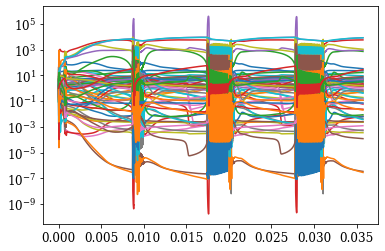

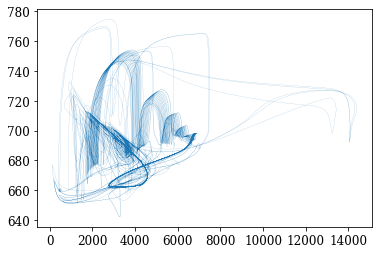

In [92]:
imp.reload(rmtchem)

Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')

m0=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
X0=Xs[m0]
epsilon=60
ev,evec=np.linalg.eig(rmtchem.jac(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2))

dt=100/np.max(np.abs(rmtchem.func(0,X0,eta,nu,k,(1+epsilon)*XD1, XD2)/X0))
print(epsilon,tscale,dt)
start=timeit.default_timer()

ts,Xts,success,m0,state=rmtchem.integrate(X0,eta,nu,k,(1+epsilon)*XD1,XD2, 2,dt,output=True,cont=True)
stop=timeit.default_timer()
print(success,stop-start)

plt.yscale('log')
plt.plot(ts/tscale,np.transpose(Xts)/X0)
plt.show()

ind1=0
ind2=7
tmax=ts[-1]
tinds=np.where(ts>tmax/2)[0]
plt.plot(Xts[ind1,tinds],Xts[ind2,tinds],zorder=-1,linewidth=0.1,alpha=1.0)
plt.show()


In [117]:
np.save('data/chaos/ts.npy',ts[tinds[::2]])
np.save('data/chaos/Xts.npy',np.array([Xts[ind1,tinds[::2]],Xts[ind2,tinds[::2]]]))

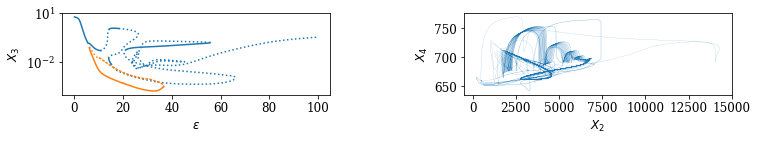

In [118]:
Xs=np.load('data/chaos/Xs1.npy')
epsilons=np.load('data/chaos/epsilons1.npy')
evals=np.load('data/chaos/evals1.npy')
Xs2=np.load('data/chaos/Xs2.npy')
epsilons2=np.load('data/chaos/epsilons2.npy')
evals2=np.load('data/chaos/evals2.npy')
Xs3=np.load('data/chaos/Xs3.npy')
epsilons3=np.load('data/chaos/epsilons3.npy')
evals3=np.load('data/chaos/evals3.npy')
ts=np.load('data/chaos/ts.npy')
Xts=np.load('data/chaos/Xts.npy')
m=np.where(np.max(np.real(evals),axis=1)>0)[0][0]
tmax=2*np.pi/(np.imag(evals[m,np.argmax(np.real(evals[m]))]))*500

lst=range(n)
lst=[3]

plt.subplots(1,2,figsize=(12,1.5))

plt.subplot(1,2,1)

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$X_3$')
inds1=np.where(np.max(np.real(evals),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],color=colors[0])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons[inds],Xs[inds,i],ls=':',color=colors[0])

inds1=np.where(np.max(np.real(evals2),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals2),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons2[inds],Xs2[inds,i],ls=':',color=colors[1])

inds1=np.where(np.max(np.real(evals3),axis=1)<0)[0]
inds2=np.where(np.max(np.real(evals3),axis=1)>=0)[0]
plt.yscale('log')
for inds in np.split(inds1, np.where(np.diff(inds1) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],color=colors[1])
for inds in np.split(inds2, np.where(np.diff(inds2) != 1)[0]+1):
    for i in lst:
        plt.plot(epsilons3[inds],Xs3[inds,i],ls=':',color=colors[1])

ax=plt.subplot(1,2,2)
ax.set_rasterization_zorder(0)
plt.xlabel(r'$X_2$')
plt.ylabel(r'$X_4$')

plt.plot(Xts[0],Xts[1],zorder=-1,linewidth=0.1,alpha=1.0)

plt.subplots_adjust(wspace=0.5,hspace=0.0)
plt.savefig('plots/fig3c.pdf',dpi=300)
plt.show()

### Empirical reaction network stoichiometry

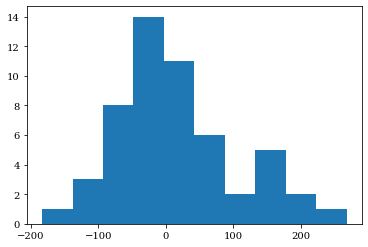

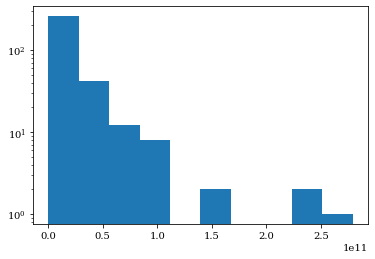

In [82]:
gas=ct.Solution('gri30.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
plt.yscale('log')
plt.hist(gas.forward_rate_constants)
plt.show()

In [84]:
gas.forward_rate_constants.shape

(325,)

In [85]:
gas.standard_gibbs_RT.shape

(53,)

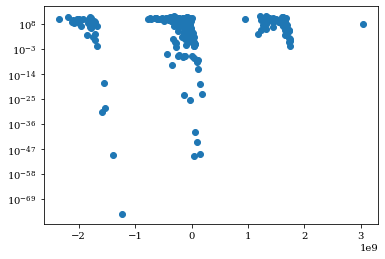

In [93]:
plt.scatter(gas.delta_gibbs,gas.forward_rate_constants)
plt.yscale('log')

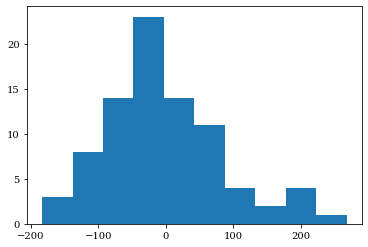

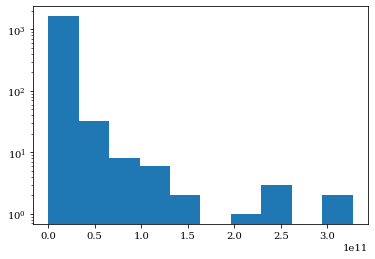

In [95]:
gas=ct.Solution('data/pyrolysis.cti')
plt.hist(gas.standard_gibbs_RT)
plt.show()
indices=np.where(gas.forward_rate_constants<1e15)[0]
plt.yscale('log')
plt.hist(gas.forward_rate_constants[indices])
plt.show()

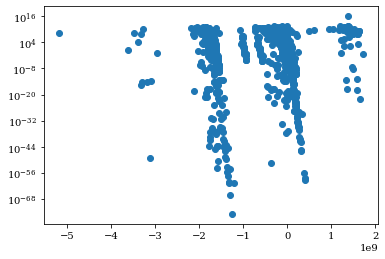

In [98]:
plt.scatter(gas.delta_gibbs,gas.forward_rate_constants)
plt.yscale('log')

### Hard chemostat, faster and better conditioned, but still difficult...

In [56]:
from rmtchem import jac
from rmtchem import func
from scipy.linalg import null_space
from scipy.optimize import root
from scipy.linalg import eig
from scipy.optimize import newton
ds=1e-3
dsmax=1e-1
dsmin=1e-16
depmin=1e-6
itmax=1e5
output=True
stop=True
tol=1e-8
stol=1e-4
ep0=0
ep1=100
if True:
    def step(x,dx,x_last,ds):
        X=np.zeros(n)
        inds=np.where(XD2>0)[0]
        inds2=np.setdiff1d(np.arange(n),inds)
        X[inds2]=x[:-1]
        ep=x[-1]
        X[inds]=(1+ep)*XD1[inds]/XD2[inds]

        f=func(t,X,eta,nu,k,(1+ep)*XD1,XD2)[inds2]
        ps=(np.log(x[:-1])-np.log(x_last[:-1])).dot(dx[:-1])/n+(x[-1]-x_last[-1])*dx[-1]-ds
        return np.concatenate([f,[ps]])

    def step_jac(x,dx,x_last,ds):
        X=np.zeros(n)
        inds=np.where(XD2>0)[0]
        inds2=np.setdiff1d(np.arange(n),inds)
        X[inds2]=x[:-1]
        ep=x[-1]
        X[inds]=(1+ep)*XD1[inds]/XD2[inds]

        a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
        b=a[inds2,:][:,inds].dot(X[inds])
        A=np.hstack([a[inds2,:][:,inds2],b[:,np.newaxis]])
        c=dx[:-1]/x[:-1]/n
        d=np.array([dx[-1]])
        B=np.hstack([c,d])

        return np.vstack([A,B])

    def sn(ep,X_last):
        sol=root(lambda X:func(0,X,eta,nu,k,(1+ep)*XD1,XD2),x0=X_last, method='hybr', options={'xtol':tol,'diag':1/X_last})
        X=sol.x
        a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
        evs,evals=np.linalg.eig(a)
        ind=np.argmin(np.abs(evs))
        return np.real(evs[ind])

    start=timeit.default_timer()
    t=0
    X=X0.copy()
    ep=ep0
    n=len(XD1)
    inds=np.where(XD2>0)[0]
    nd=len(inds)
    inds2=np.setdiff1d(np.arange(n),inds)
    X[inds]=(1+ep)*XD1[inds]/XD2[inds]
    x_last=np.concatenate([X[inds2],[ep0]])

    a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
    b=a[inds2,:][:,inds].dot(X[inds])
    A=np.hstack([a[inds2,:][:,inds2],b[:,np.newaxis]])
    ns=null_space(A)
    dx=ns[:,0]
    if dx[-1]<0:
        dx=-dx

    Xs=[]
    eps=[]
    sols=[]
    evals=[]
    count=0
    csuc=0
    bif=0
    dep=0

    try:
        while ep<ep1 and count<itmax:
            count=count+1
            if output>0:
                print('%.5f\t%.5f\t%.5f\t%.5f\t%i\t%i\t'%(ep,ds,dx[-1],dep,count, null_space(A).shape[-1]),end='\r')

            scales=np.concatenate([1/X[inds2],[1.0]])

            mat=step_jac(x_last,dx,x_last,ds)
            ev,evecs=np.linalg.eig(mat)
            test1=np.abs(ev[np.argmin(np.abs(ev))])
            test2=np.abs(ev[np.argmax(np.abs(ev))])
            b=np.zeros(len(x_last))
            b[-1]=ds
            xpred=x_last+np.linalg.solve(mat,b)
            if output>0:
                print('%.5f\t%.5f\t%.5f\t%.5f\t%i\t%i\t%.5e\t'%(ep,ds,dx[-1],dep,count, null_space(A).shape[-1],test1/test2),end='\r')

            sol=root(step,x0=xpred, jac=step_jac, args=(dx,x_last,ds), method='hybr', options={'xtol':tol,'diag':scales})

            if sol.success:
                csuc=csuc+1
                X[inds2]=sol.x[:-1]
                ep=sol.x[-1]
                X[inds]=(1+ep)*XD1[inds]/XD2[inds]
                ev,lvec,rvec=eig(jac(0,X,eta,nu,k,(1+ep)*XD1, XD2)[inds2,:][:,inds2],left=True,right=True)
                x_last=sol.x.copy()

                eps=eps+[ep]
                Xs=Xs+[X.copy()]
                evals=evals+[ev]
                sols=sols+[sol]

                if len(eps)>3 and np.sign(np.diff(eps)[-1])!=np.sign(np.diff(eps)[-2]):
                    if output>2:
                        print('\nTrying to find saddle-node\t%.6f'%(ep),end='')
                    try:
                        sep,r=newton(sn,x0=ep,args=[X],full_output=True,tol=stol)

                        bif=2
                        if output>1:
                            print('\nSaddle-node bifurcation!\t%.6f'%(sep))
                        if stop:
                            break
                    except RuntimeError:
                        bif=-1
                        print('\nFailed to converge at SN!')
                        break
                elif len(evals)>2 and np.abs(np.count_nonzero(np.real(evals[-1])>0) - np.count_nonzero(np.real(evals[-2])>0))>=2:
                    if output>2:
                        print('\nTrying to find Hopf\t%.6f'%(ep))
                    ind=np.argmin(np.abs(np.real(ev)))
                    omega=np.imag(ev[ind])

                    q=rvec[:,ind]
                    p=lvec[:,ind]/np.vdot(rvec[:,ind],lvec[:,ind])
                    if omega<0:
                        omega=-omega
                        q=q.conjugate()
                        p=p.conjugate()
                    l=lcoeff(0,X,eta,nu,k,(1+ep)*XD1,XD2,q,p,omega)
                    if l<0:
                        bif=1
                        if output>1:
                            print('\nSupercritical Hopf bifurcation!\t%.6f'%(ep))
                        if stop:
                            break
                    else:
                        bif=3
                        if output>1:
                            print('\nSubcritical Hopf bifurcation!\t%.6f'%(ep))
                        if stop:
                            break

                # dx=(sol.x-x_last)/ds
                a=jac(t,X,eta,nu,k,(1+ep)*XD1,XD2)
                b=a[inds2,:][:,inds].dot(X[inds])
                A=np.hstack([a[inds2,:][:,inds2],b[:,np.newaxis]])
                ns=null_space(A)
                dx=np.sum(ns.T.dot(dx)*ns,axis=1)

                if len(eps)>1:
                    dep=np.diff(eps)[-1]
                    if np.abs(dep) < depmin:
                        print('Failed to converge!\t%.6f'%(ep))
                        bif=-1
                        break
                dx=dx/np.linalg.norm(dx)

                if csuc>10 and sol.nfev < 1000 and ds*1.5<=dsmax:
                    ds=ds*1.5
                    csuc=0
            else:
                if ds/1.5>=dsmin:
                    ds=ds/1.5
                    csuc=0
                else:
                    print('Failed to converge!\t%.6f'%(ep))
                    bif=-1
                    break
    except KeyboardInterrupt:
        print('\nKeyboard interrupt')
        bif=-1



ValueError: x and y must have same first dimension, but have shapes (2,) and (10, 64)

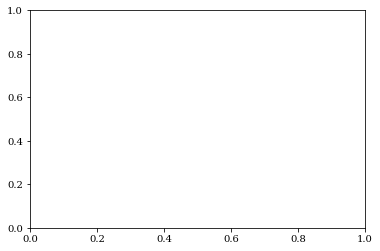

In [58]:
plt.plot(epsilons,Xs)